# Model training using Kaggle

This notebook is used to train the models for different levels of noises. All parameters are set in the Parameters section. The output are the trained model parameters ("model".pt) and the predictions for the test set as well as the test loss for each epoch.

In [ ]:
# Import of the Github repository
!git clone https://github.com/SebastianGhafafian/Circle_CNN

In [ ]:
# import libraries
import torch
from torch import nn, save, load
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import pandas as pd
from torchvision.io import read_image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import Circle
#import networks
from Circle_CNN import networks, utils


## Parameters
Setting up parameters for training and model choice.

In [3]:
# Define the train and test splits
train_split = 0.80
test_split = 1 - train_split
# Hyperparameters
learning_rate = 5e-4
batch_size = 100
epochs = 5
noise_lvl = 0.7
model_type = 'CustomCNN5' 

# Data Loader and Data Set

The binary dataset is loaded and a gaussian noise is added. The noise level is set in Parameters section.

In [110]:
# Define data setadd gaussian noise to training data
data_set = utils.CustomImageDataset(annotations_file="/kaggle/input/circle-data/data/annotations.csv",img_dir="/kaggle/input/circle-data/data/",transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    utils.AddGaussianNoise(mean = 0, std = noise_lvl)]))

# Set number of training samples
numTrainingSamples = int(len(data_set) * train_split)

# Set number of test samples
numTestSamples = int(len(data_set) - numTrainingSamples)
print(f'Number of training samples: {numTrainingSamples}')
print(f'Number of test samples: {numTestSamples}')

# Draw randomly from data
(trainData, testData) = random_split(data_set,
	[numTrainingSamples, numTestSamples],
	generator=torch.Generator().manual_seed(42))

# Define data loader of batch size 100
train_dataloader = DataLoader(trainData, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testData, batch_size=batch_size, shuffle=True)

print(f'Noise level: {noise_lvl}')

Number of training samples: 32000
Number of test samples: 8000
Noise level: 0.7


Let's do a quick check to check whether noisy images were created.

tensor(3.7629)

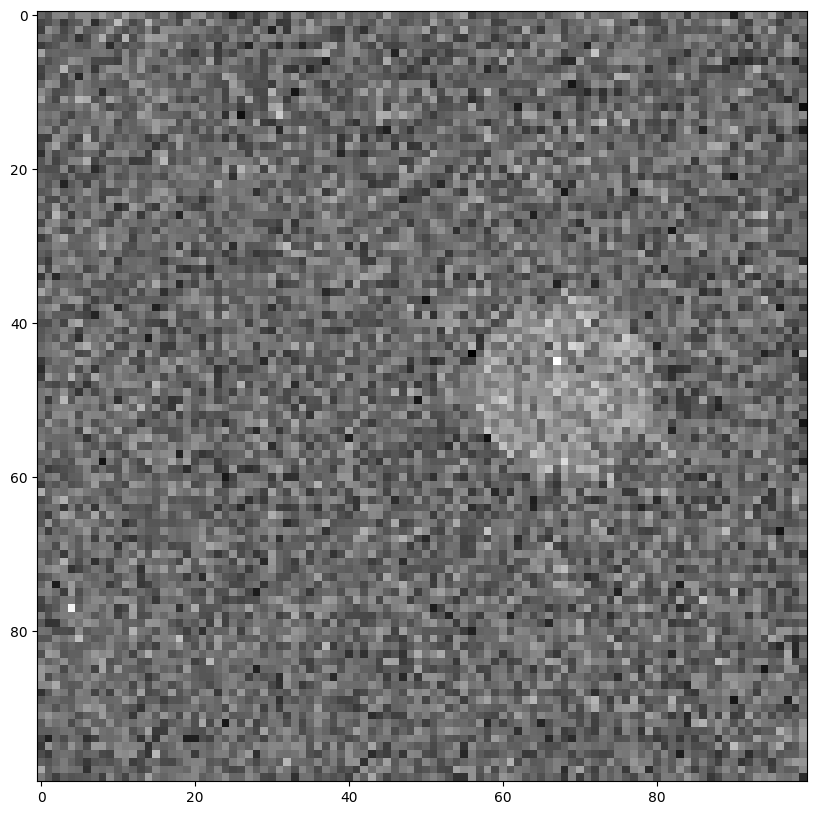

In [111]:
#draw random sample to verify noisy image is created
sample_idx = torch.randint(len(trainData), size=(1,)).item()
img, label = trainData[sample_idx]
plt.imshow(img.squeeze(), cmap = "gray")
label.dtype
torch.max(img)

# Model definition

The model should be trained using Cuda. The models' architectures are defined in networks.py. A training and test loop are defined and the model is trained.

In [112]:
# Set up training device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

# Define model's architecture
if model_type == 'CustomCNN3':
    model = networks.CustomCNN3().to(device)
elif model_type == 'CustomCNN5':
    model = networks.CustomCNN5().to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")


cuda
Number of parameters: 270527


In [114]:
# Initialize the loss function
loss_fn = nn.MSELoss()
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, label) in enumerate(dataloader):
        X = X.to(device)
        label = label.to(device)
        # Compute prediction and loss
        pred = torch.squeeze(model(X))
        loss = loss_fn(pred, label)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 20 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, label in dataloader:
            X = X.to(device)
            label = label.to(device)
            pred = torch.squeeze(model(X))
            test_loss += loss_fn(pred, label).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    #correct /= size
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss

#initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [115]:
test_loss = []

In [ ]:

# initialize a dictionary to store training history

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    L = test_loop(test_dataloader, model, loss_fn)
    test_loss.append(L)
print("Done!")


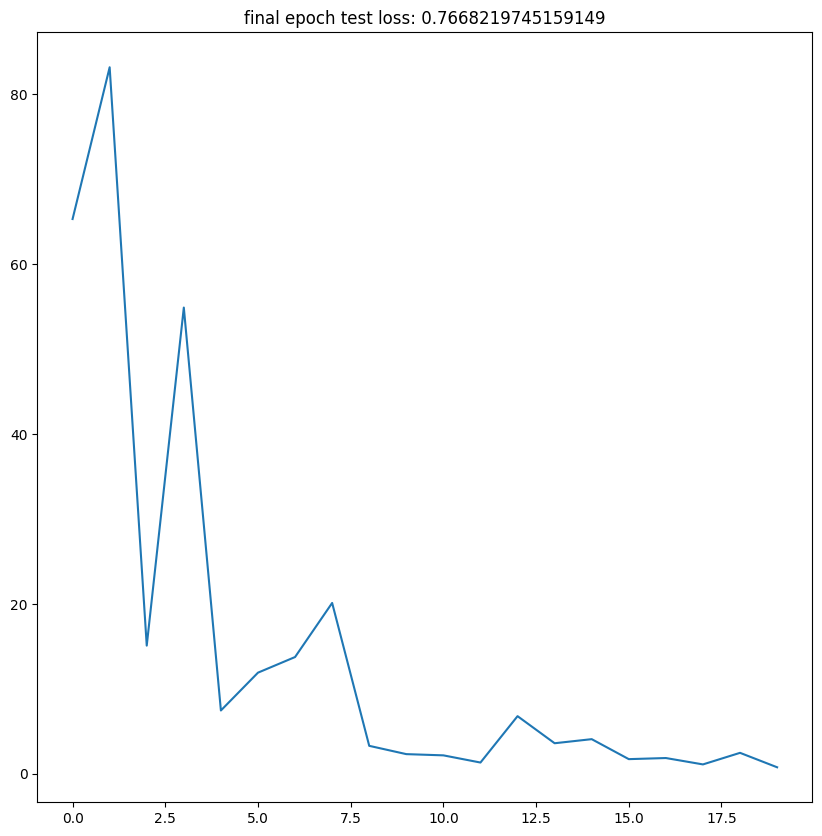

In [120]:
plt.figure()
plt.title(f"final epoch test loss: {test_loss[-1]}")
plt.plot(np.arange(len(test_loss)),test_loss)

## Short visual validation

A short visual of the estimation helps to judge the models performance and potential weaknesses.

<Figure size 800x800 with 0 Axes>

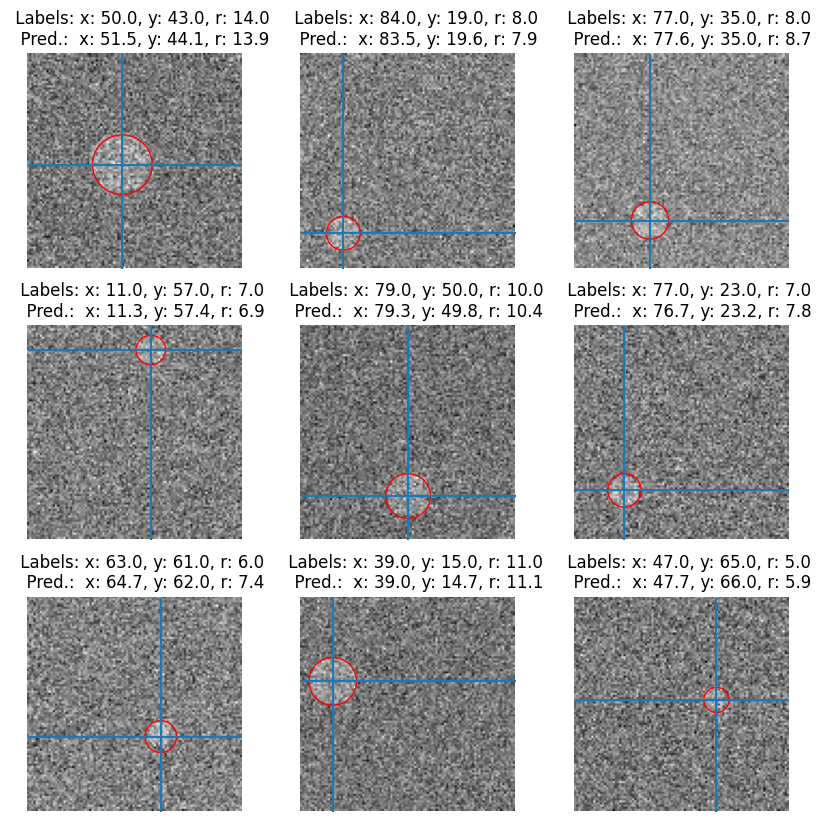

In [103]:
# visualize the model performance using the images

# set up a canvas of 3 x 3 subplots
plt.rcParams['figure.figsize'] = [10, 10]
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
fig, axes = plt.subplots( rows, cols )

# plot image and prediction
for i in range(rows):
   for j in range(cols):
      # get random index of test sample
      sample_idx = torch.randint(len(testData), size=(1,)).item()
      # get random test sample
      img, label = testData[sample_idx]
      # whats happening here???
      img.unsqueeze_(1)
      # set image to device
      img = img.to(device)
      # get prediction vector (x,y,r) from model
      pred = model(img).squeeze()
      # extract predicted variables
      x_pred, y_pred, r_pred = pred[0].item(), pred[1].item(), pred[2].item()
      img = img.to('cpu')
    
      # figure.add_subplot(rows, cols, i)
      axes[i,j].set_title(f" Labels: x: {label[0]}, y: {label[1]}, r: {label[2]}\n  Pred.:  x: {x_pred:.1f}, y: {y_pred:.1f}, r: {r_pred:.1f}")
      axes[i,j].axis("off")
      axes[i,j].imshow(img.squeeze(), cmap="gray") #what does this do???
      axes[i,j].hlines([x_pred,x_pred],0,100)
      axes[i,j].vlines([y_pred,y_pred],0,100)
      circ = Circle((y_pred,x_pred),r_pred,fill = False, edgecolor = "r")
      axes[i,j].add_patch(circ)

## Test Predictions

The predictions for the final model are saved for the test data set for model validation.

In [121]:
# Get test predictions
test_dataloader = DataLoader(testData, batch_size=1, shuffle=False)
size = len(test_dataloader.dataset)
num_batches = len(test_dataloader)
predictions = np.zeros([size,3])
labels = np.zeros([size,3])
# Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
# also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
with torch.no_grad():
    i = 0
    for X, label in test_dataloader:

        X = X.to(device)
        labels[i,:]=label
        label = label.to(device)
        pred = torch.squeeze(model(X))
        predictions[i,:]=(pred.cpu().numpy())
        i += 1 
# Export as .csv
predictions = np.round(predictions)
predictions_df = pd.DataFrame({'image':testData.indices,'x': labels[:,0],'y': labels[:,1], 'r':labels[:,2],'noise':noise_lvl,'x_hat': predictions[:,0],'y_hat':predictions[:,1], 'r_hat':predictions[:,2]})
predictions_df.to_csv(f'predictions_{model_type}_noise_lvl_{noise_lvl}.csv',index=False)


## Export the model

In [122]:
# extract training data indexes for validation that every model has been trained on the same training
df_train_data = pd.DataFrame({'train id':testData.indices})
df_train_data.to_csv(f'{model.__class__.__name__}_noise_{noise_lvl}_test_idx.csv')

In [123]:
# export training history of test loss
loss_df = pd.DataFrame({f'Loss':test_loss})
loss_df.to_csv(f'{model.__class__.__name__}_noise_{noise_lvl}.csv')

In [124]:
# export the model parameters
with open(f'{model.__class__.__name__}_noise_lvl_{noise_lvl}.pt', 'wb') as f:
    save(model.state_dict(), f)
    print('model has been saved')

model has been saved
